In [22]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os
from scipy import stats


In [23]:
url1 = "https://raw.githubusercontent.com/swetajainh/immo-eliza-MAS-FN-analysis/main/data/Cleaned/cleaned_apartment.csv"
df_clean = pd.read_csv(url1, index_col = 0)

# Filter the DataFrame for rows with "apartment" type in the "property_type" column
df_apartment = df_clean[df_clean["property_type"] == "APARTMENT"]
df_apartment.shape


(2384, 30)

In [24]:
df_apartment.dtypes

url                         object
id                         float64
region                      object
province                    object
locality                    object
zip_code                   float64
Longitude                  float64
Latitude                   float64
property_type               object
property_subtype            object
price                      float64
number_rooms               float64
living_area                float64
kitchen                     object
furnished                  float64
fireplace                  float64
terrace                      int64
terrace_area               float64
garden                       int64
garden_area                float64
surface_land               float64
number_facades             float64
swimming_pool               object
building_state              object
energy_type                 object
EPC_score                   object
EnergyConsumptionPerSqm    float64
parking_outdoor            float64
parking_indoor      

**Graphs**

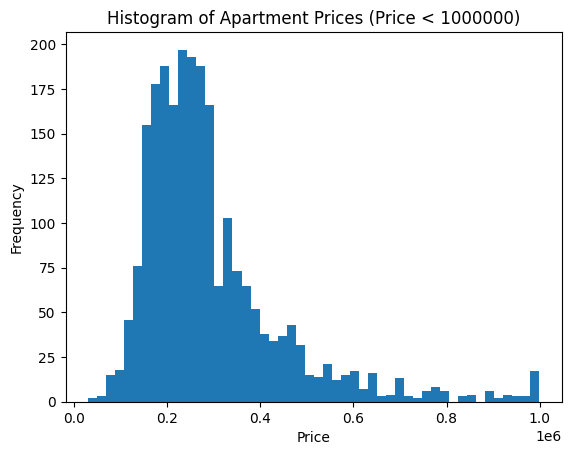

In [25]:
# Plot histogram for the 'price' column in the subset of the DataFrame where 'price' is less than 1000000
plt.hist(df_apartment[df_apartment['price'] < 1000000]['price'], bins=50)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Apartment Prices (Price < 1000000)')
plt.show()


In [26]:
# Filter the DataFrame for prices less than 1000000
subset_df = df_apartment[df_apartment['price'] < 1000000]['price']

# Calculate mean, median, and mode
mean_price = subset_df.mean()
median_price = subset_df.median()
mode_price = subset_df.mode()[0]

# Create a histogram
fig = go.Figure()

# Add a histogram trace
fig.add_trace(go.Histogram(x=subset_df, name='Price'))

# Add vertical lines for mean, median, and mode
fig.add_vline(x=mean_price, line_dash="dash", line_color="magenta", name="Mean")
fig.add_vline(x=median_price, line_dash="dash", line_color="blue", name="Median")
fig.add_vline(x=mode_price, line_dash="dash", line_color="green", name="Mode")

# Update layout
fig.update_layout(
    title='Distribution of Prices for Apartments (Price < 1000000)',
    xaxis_title='Price',
    yaxis_title='Number of Apartments',
    bargap=0.1  # Gap between bars
)

# Show the plot
fig.show()




In the above histogram we can see that the bin with the price between 200,000 to 400,000 has the most numbers of observation.

<Axes: xlabel='price'>

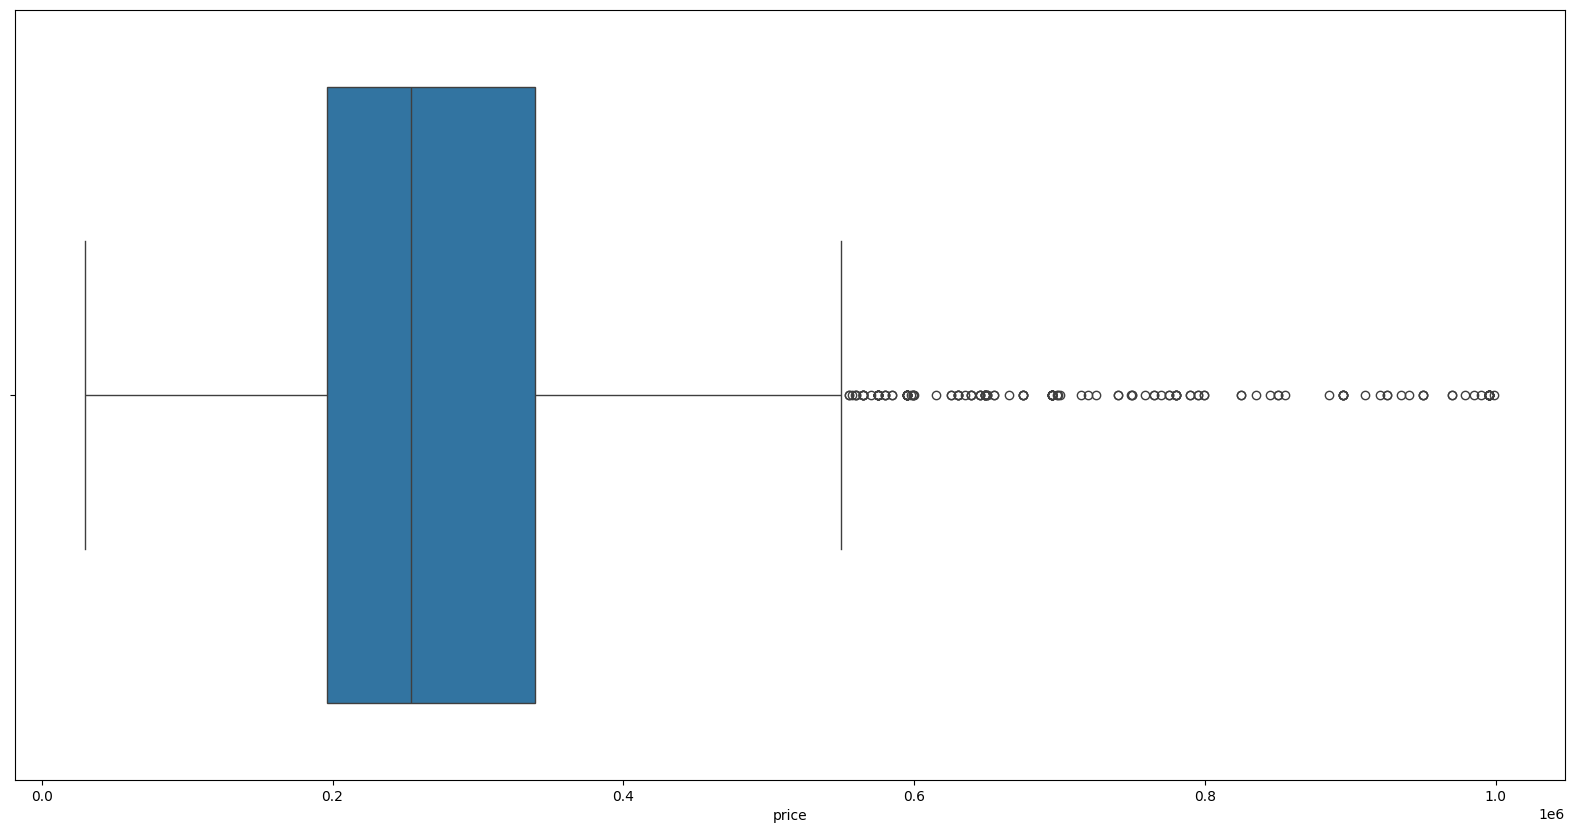

In [27]:
# Create boxplot for price
plt.figure(figsize=(20,10))
sns.boxplot(x=df_apartment[df_apartment['price'] < 1000000]['price'])

a lot of aparments over 650,000 shows as outliers in the box plot.


## **Correlations**

### **Numerical Variables**

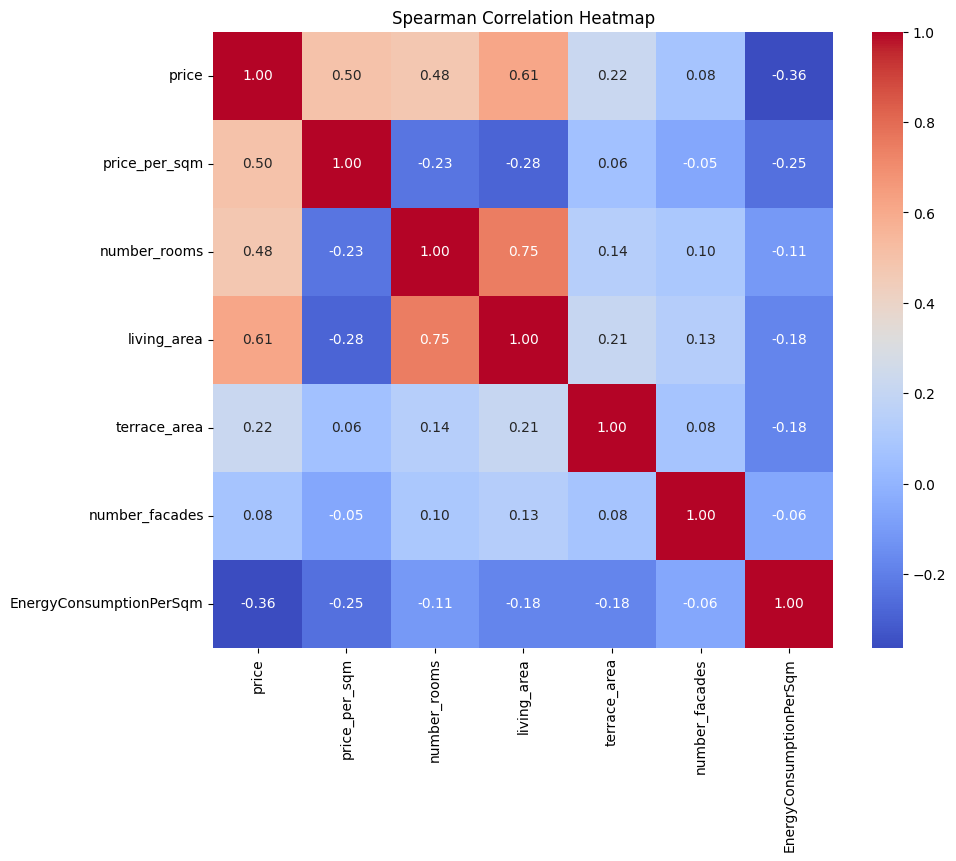

In [28]:
# Specify numerical columns
numerical_columns = ['price', 'price_per_sqm', 'number_rooms', 'living_area', 'terrace_area', 'number_facades', 'EnergyConsumptionPerSqm']

# Select numerical data
numerical_df = df_apartment[numerical_columns]

# Calculate Spearman correlation matrix
correlation_matrix = numerical_df.corr(method='spearman')

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Heatmap')
plt.show()


#### - price and living area

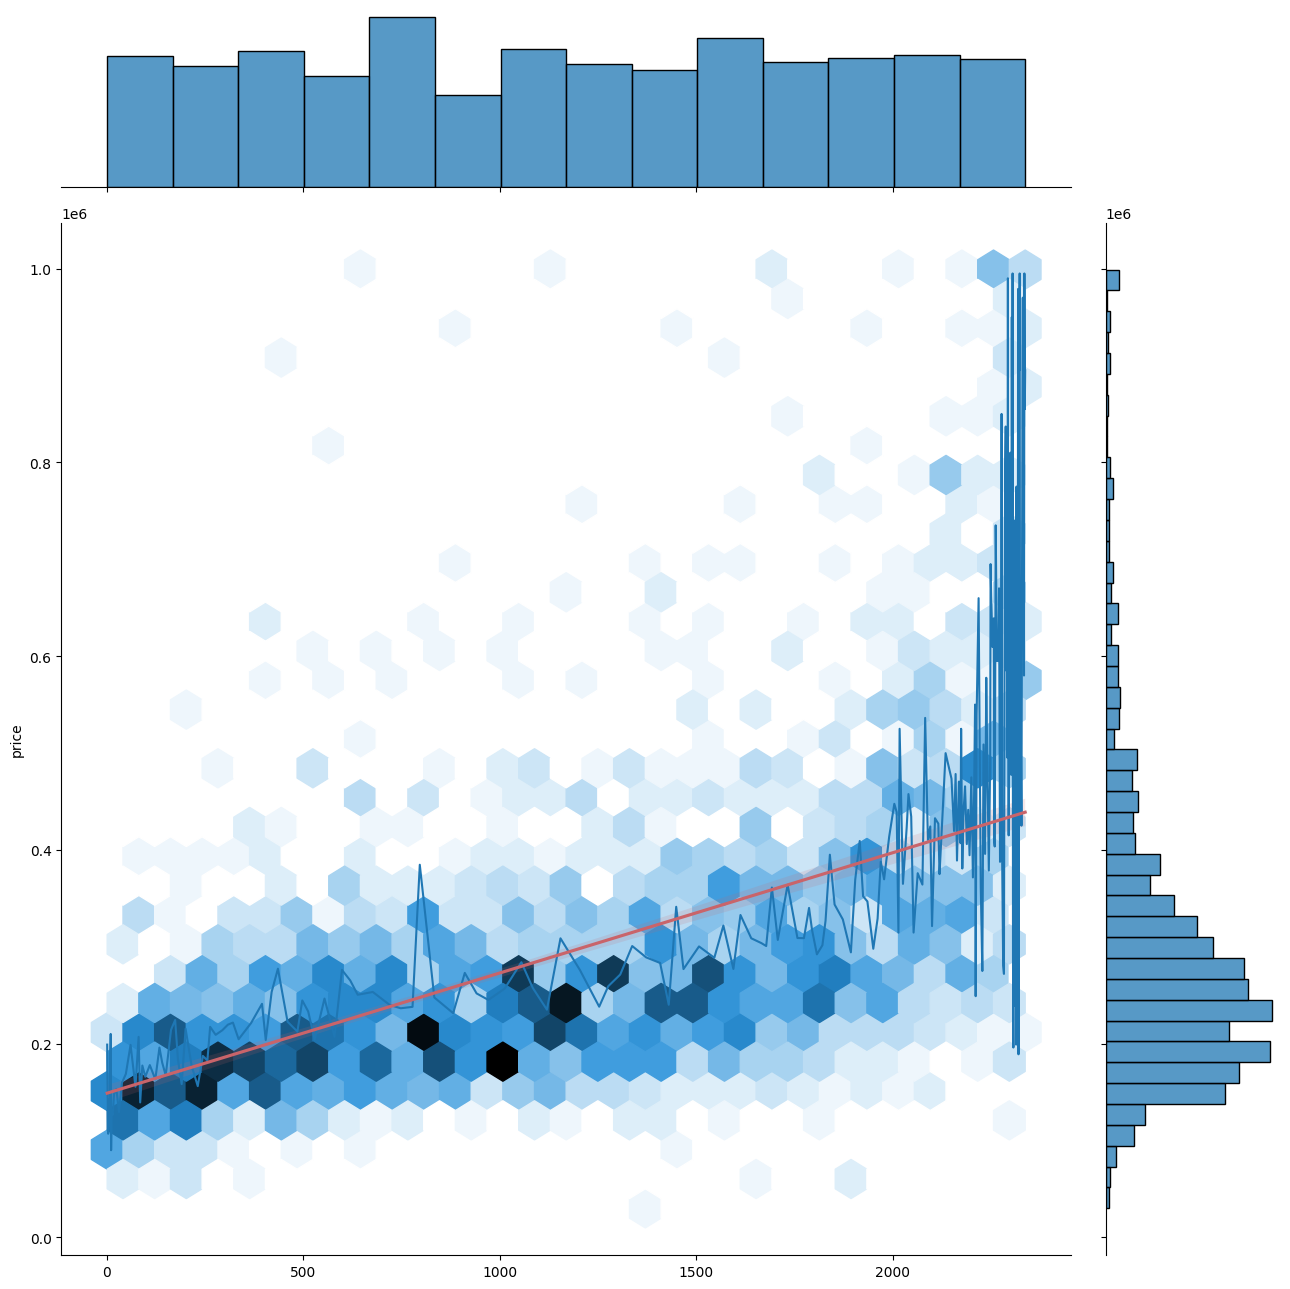

In [29]:
# Filter the DataFrame for prices under 1 million
df_filtered = df_apartment[df_apartment['price'] < 1000000]

# Create the joint plot
plot = sns.jointplot(x=stats.rankdata(df_filtered['living_area']), 
                     y='price', data=df_filtered,
                     height=13, kind="hex")

# Add a line plot of living area vs. price
sns.lineplot(data=df_filtered, 
             x=stats.rankdata(df_filtered['living_area']), 
             y='price', errorbar=None, ax=plot.ax_joint)

# Add a regression plot of living area vs. price
sns.regplot(data=df_filtered, 
            x=stats.rankdata(df_filtered['living_area']), 
            y='price', scatter=False, robust=False, color='#c9646a', ax=plot.ax_joint)

# Show the plot
plt.show()

# Save the plot locally
plot.savefig("price_living_area_filtered.png", dpi=300)

# Optionally, move the saved plot to the desired directory
# import shutil
# shutil.move("price_living_area_filtered.png", "https://github.com/swetajainh/immo-eliza-MAS-FN-analysis/tree/main/Report/")



The Price of a house is correlated with its area: The higher is the area, higher is the price.

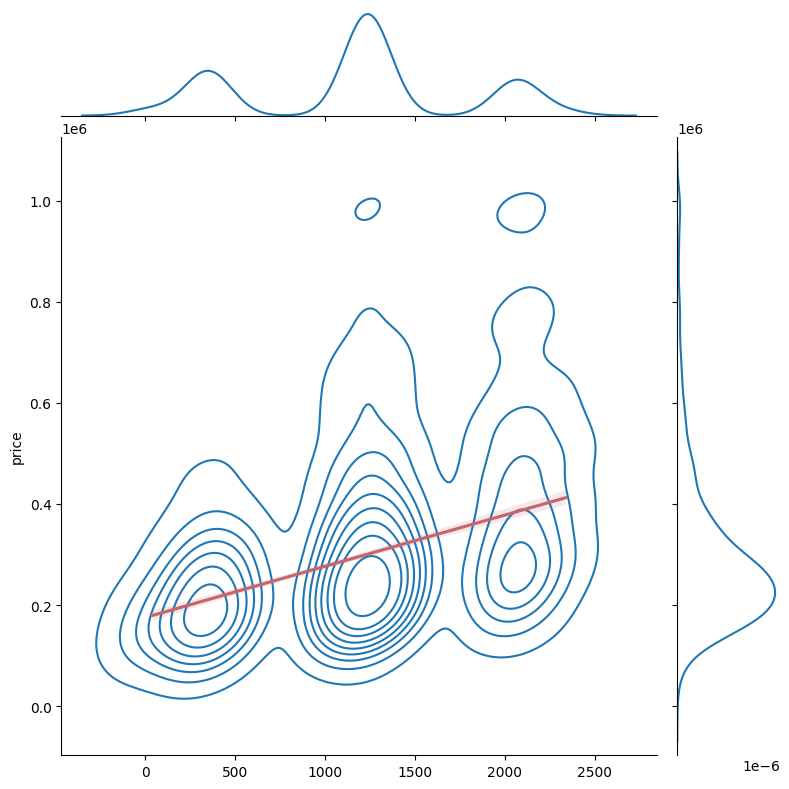

In [30]:
# Filter the DataFrame for prices under a certain threshold (e.g., 1 million)
df_filtered_price = df_apartment[df_apartment['price'] < 1000000]

# Create the joint plot with KDE for filtered data
plot = sns.jointplot(x=stats.rankdata(df_filtered_price['number_rooms']), 
                     y=df_filtered_price['price'], 
                     height=8, 
                     kind="kde")

# Add a regression line
plot.plot_joint(sns.regplot, color='#c9646a', scatter=False, robust=False)

# Show the plot
plt.show()



### **Categorical Variables**

#### - EPC score

<Axes: xlabel='EPC_score', ylabel='count'>

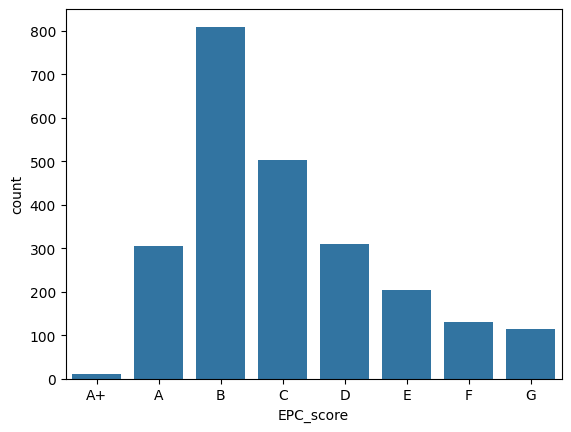

In [31]:
ordered_EPC = ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Not specified']

#list of EPC_scores, excluding "A++" and "Not specified"
ordered_EPC_aplus_to_g = ['A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G'] 

sns.countplot(x="EPC_score", data = df_apartment, order = ordered_EPC_aplus_to_g)

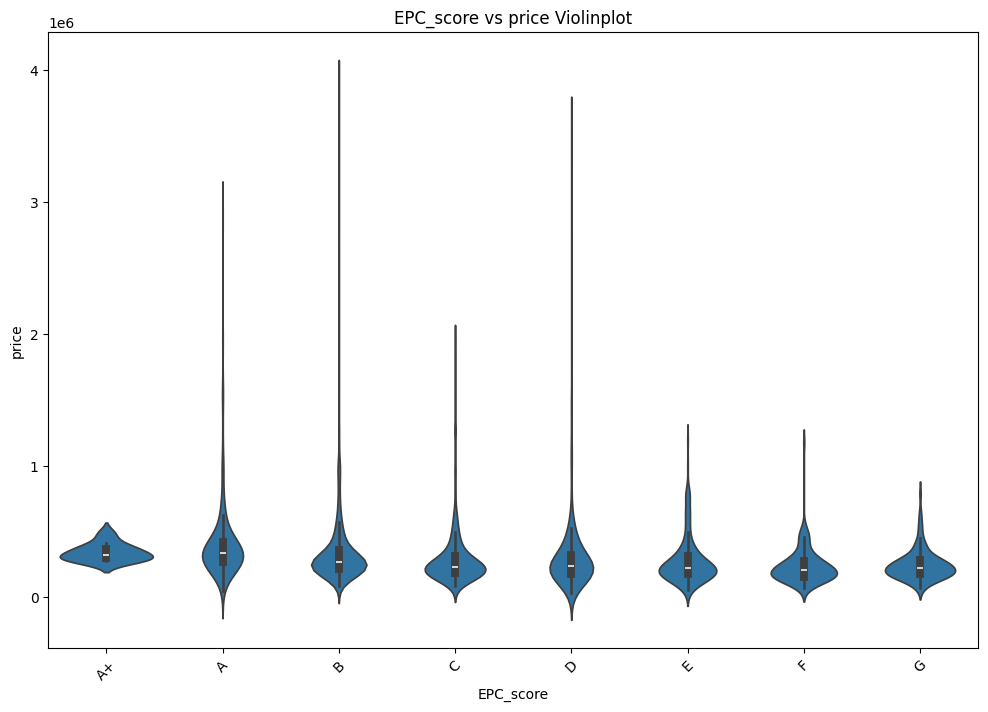

In [32]:
def categorical_numeric_correlation_violin(df_apartment, categorical_column, numeric_column, order=None):
    # Filter out rows where the categorical column is 'None'
    df_filtered = df_apartment[df_apartment[categorical_column] != 'None']
    
    # Sort categories alphabetically if order is not specified
    if order is None:
        categories_sorted = df_filtered[categorical_column].unique()
        categories_sorted.sort()
        order = categories_sorted
    
    # Create violin plots for each category
    plt.figure(figsize=(12, 8))
    sns.violinplot(x=categorical_column, y=numeric_column, data=df_filtered, order=order)
    plt.title(f'{categorical_column} vs {numeric_column} Violinplot')
    plt.xlabel(categorical_column)
    plt.ylabel(numeric_column)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

# Example usage with specified order
ordered_EPC_aplus_to_g = ['A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
categorical_numeric_correlation_violin(df_apartment, 'EPC_score', 'price', order=ordered_EPC_aplus_to_g)


[Text(0.5, 1.0, 'EPC_score versus Price'), Text(0, 0.5, 'Price per sqm in €')]

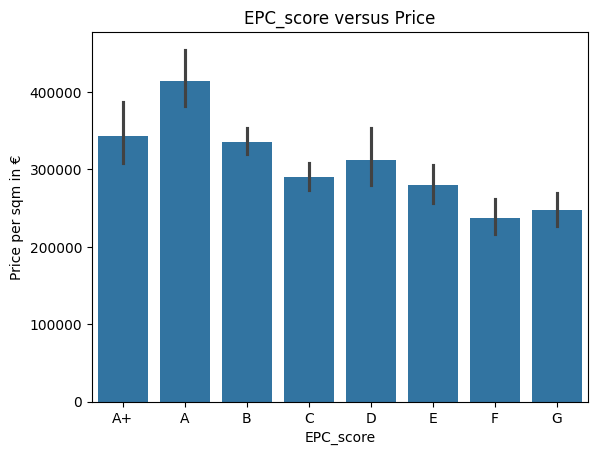

In [33]:
sns.barplot(x="EPC_score", y="price", order=ordered_EPC_aplus_to_g,
             data=df_apartment).set(title = "EPC_score versus Price", ylabel='Price per sqm in €')

[Text(0.5, 1.0, 'EPC_score versus Price_per_sqm'),
 Text(0, 0.5, 'Price per sqm in €')]

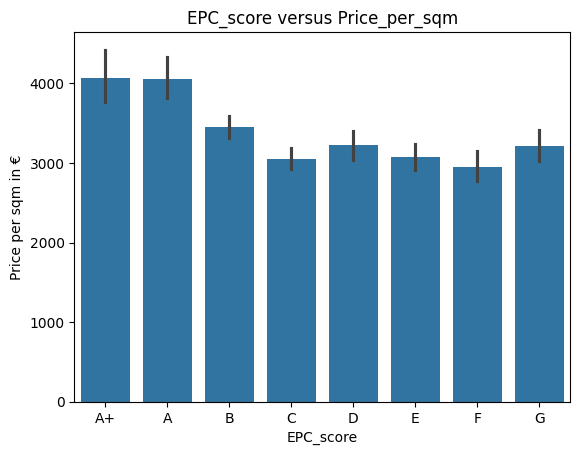

In [34]:
sns.barplot(x="EPC_score", y="price_per_sqm", order=ordered_EPC_aplus_to_g,
             data=df_apartment).set(title = "EPC_score versus Price_per_sqm", ylabel='Price per sqm in €')

[Text(0.5, 1.0, 'EPC score versus Price per Region'),
 Text(0, 0.5, 'Price in €')]

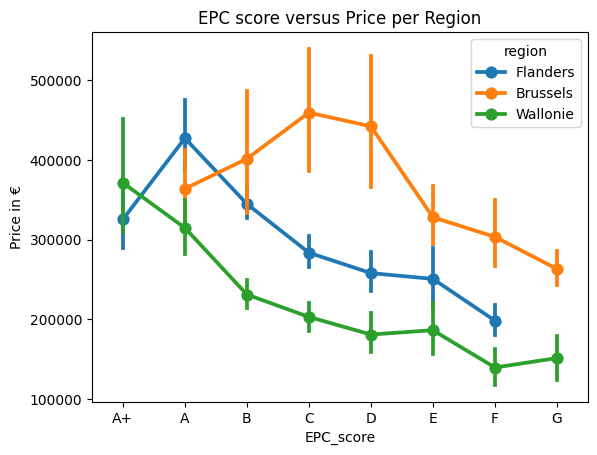

In [35]:
sns.pointplot(x="EPC_score", y="price", hue = "region",data=df_apartment, order=ordered_EPC_aplus_to_g).set(title = "EPC score versus Price per Region", ylabel='Price in €')

#### - Energy type

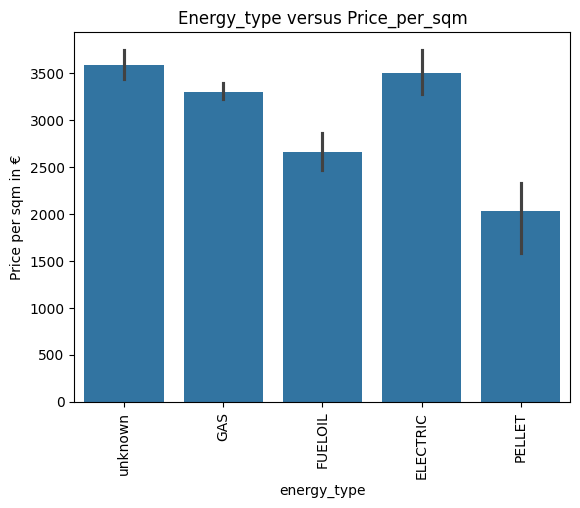

In [36]:
# Create the bar plot
sns.barplot(x="energy_type", y="price_per_sqm", data=df_apartment)

# Set title and ylabel
plt.title("Energy_type versus Price_per_sqm")
plt.ylabel("Price per sqm in €")

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Show the plot
plt.show()


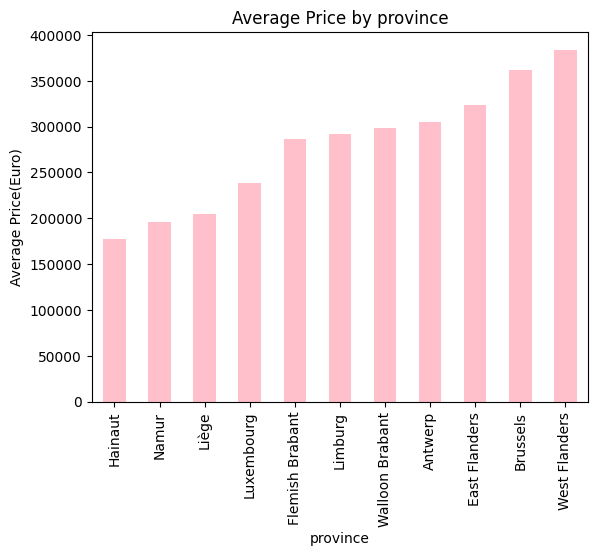

In [39]:
# create a func for the Average Price by provinces of Belguim
def PlotBar_1(df):
    categorical_column = 'province'
    numerical_column = 'price'
    grouped_df = df.groupby(categorical_column)[numerical_column].mean()
    grouped_df = grouped_df.sort_values()
    grouped_df.plot(kind='bar' ,color='pink')
    plt.xlabel(categorical_column)
    plt.ylabel('Average Price(Euro)')
    plt.title(f'Average Price by {categorical_column}')
    plt.savefig("output",dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    return
PlotBar_1(df_apartment)

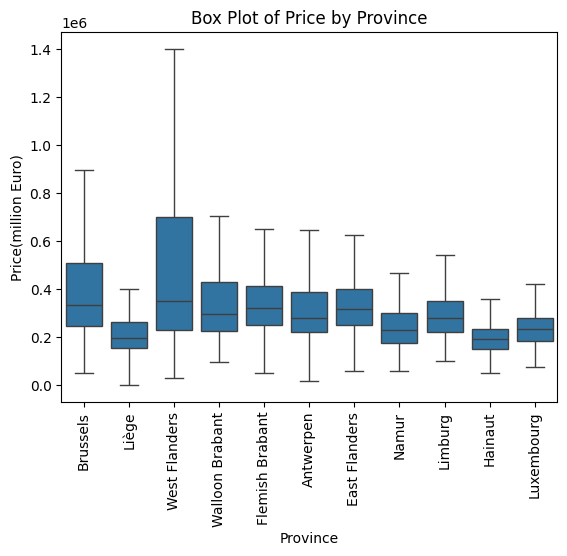

In [ ]:
def Price_by_province_boxplot(df):
    # Create a box plot using seaborn
    sns.boxplot(x='province1', y='price', data=df_apartment, showfliers=False)
    # Set the labels and title
    plt.xlabel('Province')
    plt.ylabel('Price(million Euro)')
    plt.title('Box Plot of Price by Province')
    # Rotate x-axis labels if needed
    plt.xticks(rotation=90)
    plt.savefig('output', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    return 
Price_by_province_boxplot(df_apartment)

In [40]:
import plotly.express as px
def plot_stack_histogram(data, province_column, locality_column, price_column):
    # Create a stacked histogram plot
    fig_hist = px.histogram(data, x=province_column, color=locality_column,
                            title='Stacked Histogram of Locality within Each Province',
                            labels={province_column: 'Province', locality_column: 'Locality'},
                            template='plotly_white', barmode='stack')

    # Update layout for histogram plot
    fig_hist.update_layout(xaxis_title='Province', yaxis_title='Frequency')

    # Create annotations for median price
    median_prices = data.groupby(province_column)[price_column].median().reset_index()
    annotations = []
    prev_y = None
    for i, row in median_prices.iterrows():
        annotations.append(dict(x=row[province_column], y=row[price_column],
                                text=f'Median Price: {row[price_column]:.2f}', showarrow=False))

    # Create a scatter plot for annotations
    fig_ann = px.scatter(x=median_prices[province_column], y=median_prices[price_column],
                         text=median_prices[price_column].apply(lambda x: f'Median Price: {x:.2f}'))

    # Update layout for scatter plot
    fig_ann.update_traces(mode='text')

    # Display the plots side by side
    fig_hist.show()
    fig_ann.show()

plot_stack_histogram(df_apartment, 'province', 'locality', 'price')

In [42]:
# Import necessary libraries
import plotly.express as px
from IPython.display import display

# Create a scatter map
fig = px.scatter_mapbox(
    df_apartment,
    lat="Latitude",
    lon="Longitude",
   
    hover_name="url",
    zoom=10,
)
# Update the map layout
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=0, b=0),
)

# **Data interpretation**

**1- How many observations and features do you have?**

**2- What is the proportion of missing values per column?**

**3- Which variables would you delete and why?**

**4- What variables are most subject to outliers?**

**5- How many qualitative and quantitative variables are there? How would you transform the qualitative values into numerical values?** 





**6- What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?**
The target variable is the price of apartment and house. 

Based on the correlation heatmap, we can summarize the importance of various features for predicting apartment prices as follows:

- Living area has a relatively strong positive correlation with price (0.63), indicating that larger living areas tend to have higher prices.
- The number of rooms also shows a positive correlation with price (0.50), suggesting that apartments with more rooms tend to be more expensive.
- Energy consumption per square meter has a moderate negative correlation with price (-0.35), implying that apartments with lower energy consumption tend to have higher prices.
- The number of facades has a small positive correlation with price (0.08), suggesting that apartments with more facades may have slightly higher prices, although this correlation is weak.
- Terrace area has a moderate positive correlation with price (0.28), indicating that apartments with larger terrace areas tend to have higher prices.

Overall, living area, number of rooms, and energy consumption per square meter appear to be the most important features for predicting apartment prices, while the number of facades and terrace area have weaker associations with price.

**7- How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?**

The most significant positive correlation is between living area and number of rooms (0.74), which suggests that larger apartments tend to have more rooms. This relationship is intuitive, as larger apartments typically have more space available for additional rooms.


**8- How are the number of properties distributed according to their surface?**

The distribution of properties based on their surface can be visualized using a histogram. In this visualization, the x-axis represents different intervals or bins of surface areas, while the y-axis represents the count or frequency of properties falling within each interval. 

In [ ]:
import plotly.express as px

# Filter apartments with a price lower than 1 million
filtered_apartments = df_apartment[df_apartment['price'] < 1000000]

# Create an interactive histogram using Plotly Express
fig = px.histogram(filtered_apartments, x='living_area', nbins=20, 
                   labels={'living_area': 'Living Area', 'count': 'Number of Properties'},
                   title='Distribution of Properties by Living Area')

# Show the plot
fig.show()


**9- Which five variables do you consider the most important and why?**

**10- What are the least/most expensive municipalities in Belgium/Wallonia/Flanders? (in terms of price per m², average price, and median price)**

In [ ]:
df_apartment.groupby('province')['price_per_sqm'].agg('mean').sort_values() 

province
Hainaut            2160.494927
Liège              2225.655551
Namur              2570.598978
Luxembourg         2658.961685
Limburg            2902.828599
Antwerp            3323.522714
East Flanders      3390.708649
Walloon Brabant    3399.548636
Flemish Brabant    3808.347235
Brussels           3996.016579
West Flanders      6278.970753
Name: price_per_sqm, dtype: float64

**What are the most & less expensive municipalities in Belgium? (Average price, median price, price per square meter)**

In [ ]:
# most expensive city in Belgium

most_expensive = df_apartment.groupby('province')['price_per_sqm'].agg('mean').sort_values().idxmax()
most_expensive 

'West Flanders'

In [ ]:
filt = df_apartment['province'] == most_expensive 

average = df_apartment[filt]['price'].mean()
median = df_apartment[filt]['price'].median()
price_sqm = df_apartment[filt]['price_per_sqm'].mean()

print(f'The most expensive municipalities in Belgium is {most_expensive}.')
print(f'Average price : {average} , median :{median}   price per square meter : {price_sqm}')

The most expensive municipalities in Belgium is West Flanders.
Average price : 611199.9471007121 , median :349000.0   price per square meter : 6278.970752797559


In [ ]:
# less expensive province in Belgium
less_expensive = df_apartment.groupby('province')['price_per_sqm'].agg('mean').sort_values().idxmin() 
less_expensive 

'Hainaut'

In [ ]:
filt = df_apartment['province'] == less_expensive 

average = df_apartment[filt]['price'].mean()
median = df_apartment[filt]['price'].median()
price_sqm = df_apartment[filt]['price_per_sqm'].mean()

print(f'The less expensive municipalities in Belgium is {less_expensive}.')
print(f'Average price : {average} , median :{median}   price per square meter : {price_sqm}')

The less expensive municipalities in Belgium is Hainaut.
Average price : 207949.47507331378 , median :190000.0   price per square meter : 2160.4949266862172


**What are the most & less expensive municipalities in Wallonia? (Average price, median price, price per square meter)**

In [ ]:
# most expensive city in Wallonie

filt1 = df_apartment['region'] == 'Wallonie'

df_wallonie = df_apartment[filt1]

most_expensive = df_wallonie.groupby('province')['price_per_sqm'].agg('mean').sort_values().idxmax()

filt2 = df_wallonie['province'] == most_expensive 

average = df_wallonie[filt2]['price'].mean()
median = df_wallonie[filt2]['price'].median()
price_sqm = df_wallonie[filt2]['price_per_sqm'].mean()

print(f'The most expensive municipalities in Wallonie is {most_expensive}.')
print(f'Average price : {average} , median :{median}   price per square meter : {price_sqm}')

The most expensive municipalities in Wallonie is Walloon Brabant.
Average price : 340544.7832167832 , median :297500.0   price per square meter : 3399.5486363636364


In [ ]:
# less expensive city in Wallonie

less_expensive = df_wallonie .groupby('province')['price_per_sqm'].agg('mean').sort_values().idxmin() 
less_expensive 

filt3 = df_wallonie['province'] == less_expensive 

average = df_wallonie[filt3]['price'].mean()
median = df_wallonie[filt3]['price'].median()
price_sqm = df_wallonie[filt3]['price_per_sqm'].mean()

print(f'The less expensive municipalities in Wallonie is {less_expensive}.')
print(f'Average price : {average} , median :{median}   price per square meter : {price_sqm}')

The less expensive municipalities in Wallonie is Hainaut.
Average price : 207949.47507331378 , median :190000.0   price per square meter : 2160.4949266862172


**What are the most & less expensive municipalities in Flanders? (Average price, median price, price per square meter)**

In [ ]:
# most expensive city in Flanders
filt1 = df_apartment['region'] == 'Flanders'

df_flanders = df_apartment[filt1]

most_expensive = df_flanders.groupby('province')['price_per_sqm'].agg('mean').sort_values().idxmax()

filt2 = df_flanders['province'] == most_expensive 

average = df_flanders[filt2]['price'].mean()
median = df_flanders[filt2]['price'].median()
price_sqm = df_flanders[filt2]['price_per_sqm'].mean()

print(f'The most expensive municipalities in Flanders is in {most_expensive}.')
print(f'Average price : {average} , median :{median}   price per square meter : {price_sqm}')

The most expensive municipalities in Flanders is in West Flanders.
Average price : 611199.9471007121 , median :349000.0   price per square meter : 6278.970752797559


In [ ]:
# Less expensive city in Flanders
filt1 = df_apartment['region'] == 'Flanders'

df_flanders = df_apartment[filt1]

less_expensive = df_flanders.groupby('province')['price_per_sqm'].agg('mean').sort_values().idxmin()

filt2 = df_flanders['province'] == less_expensive 

average = df_flanders[filt2]['price'].mean()
median = df_flanders[filt2]['price'].median()
price_sqm = df_flanders[filt2]['price_per_sqm'].mean()

print(f'The less expensive municipalities in Flanders is in {less_expensive}.')
print(f'Average price : {average} , median :{median}   price per square meter : {price_sqm}')


The less expensive municipalities in Flanders is in Limburg.
Average price : 310595.7971014493 , median :275000.0   price per square meter : 2902.828599033817


**What are the most & less expensive municipalities in Brussels? (Average price, median price, price per square meter)**

In [ ]:
# Filter data for Brussels region
filt_brussels = df_apartment['region'] == 'Brussels'
df_brussels = df_apartment[filt_brussels]

# Find the most expensive municipality in Brussels
most_expensive_municipality = df_brussels['price_per_sqm'].idxmax()

# Get the data for the most expensive municipality
most_expensive_data = df_brussels.loc[most_expensive_municipality]

# Print results
print(f'The most expensive municipality in Brussels is {most_expensive_data["province"]}.')
print(f'Average price: {most_expensive_data["price"]}, median price: {most_expensive_data["price"]}, mean price per square meter: {most_expensive_data["price_per_sqm"]}')


The most expensive municipality in Brussels is Brussels.
Average price: 3324000.0, median price: 3324000.0, mean price per square meter: 10898.36


In [ ]:
# Filter data for Brussels region
filt_brussels = df_apartment['region'] == 'Brussels'
df_brussels = df_apartment[filt_brussels]

# Find the least expensive municipality in Brussels
least_expensive_municipality = df_brussels['price_per_sqm'].idxmin()

# Get the data for the least expensive municipality
least_expensive_data = df_brussels.loc[least_expensive_municipality]

# Print results
print(f'The least expensive municipality in Brussels is {least_expensive_data["province"]}.')
print(f'Average price: {least_expensive_data["price"]}, median price: {least_expensive_data["price"]}, mean price per square meter: {least_expensive_data["price_per_sqm"]}')

The least expensive municipality in Brussels is Brussels.
Average price: 50000.0, median price: 50000.0, mean price per square meter: 375.94
